In [1]:
from tqdm import tqdm
import warnings
import time
warnings.filterwarnings('ignore')
import pickle
from datetime import timedelta, date
import FinanceDataReader as fdr

import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_columns', None)

import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults

from sklearn.model_selection import ParameterGrid

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

import matplotlib.pyplot as plt

In [2]:
data = fdr.DataReader('005930', '2020-07-22', '2021-07-22')

data = data.reset_index()
data = data[['Date', 'Close']]
data.columns = ['ds', 'y']

In [3]:
data['dif'] = data['y'] - data['y'].shift(1)

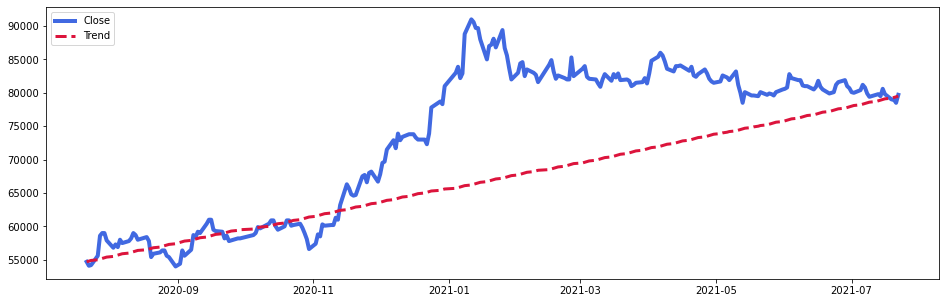

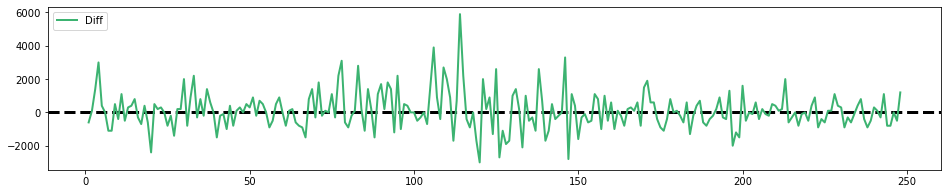

In [62]:
plt.figure(figsize=(16, 5))
plt.plot(data['ds'], data['y'], c='royalblue', linewidth=4, label='Close')
plt.plot(data['ds'], np.arange(data.iloc[0,1], data.iloc[-1, 1], 100)[:249], '--', c='crimson', linewidth=3, label='Trend')
plt.legend(loc='upper left')


plt.figure(figsize=(16, 3))
plt.axhline(0, color='k', linestyle='--', linewidth=3)
plt.plot(data['dif'], c='mediumseagreen', linewidth=2, label='Diff')
plt.legend(loc='upper left')

In [69]:
#ARIMA
model_arima = auto_arima(data['y'].values, trace=False, 
                         error_action='ignore', 
                         start_p=0, start_q=0, max_p=2, max_q=2, 
                         suppress_warnings=True, stepwise=False, seasonal=False)

model_fit = model_arima.fit(data['y'].values)

ORDER = model_fit.order

X = data['y'].values
X = X.astype('float32')

model = ARIMA(X, order = ORDER)
model_fit = model.fit(trend = 'c', full_output = True, disp = 1)

In [70]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  248
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2095.521
Method:                           css   S.D. of innovations           1130.871
Date:                Sun, 22 Aug 2021   AIC                           4195.042
Time:                        15:03:09   BIC                           4202.069
Sample:                             1   HQIC                          4197.871
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.8065     71.810      1.404      0.160     -39.939     241.552
==============================================================================
"""

In [4]:
data = data.drop('dif', axis=1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


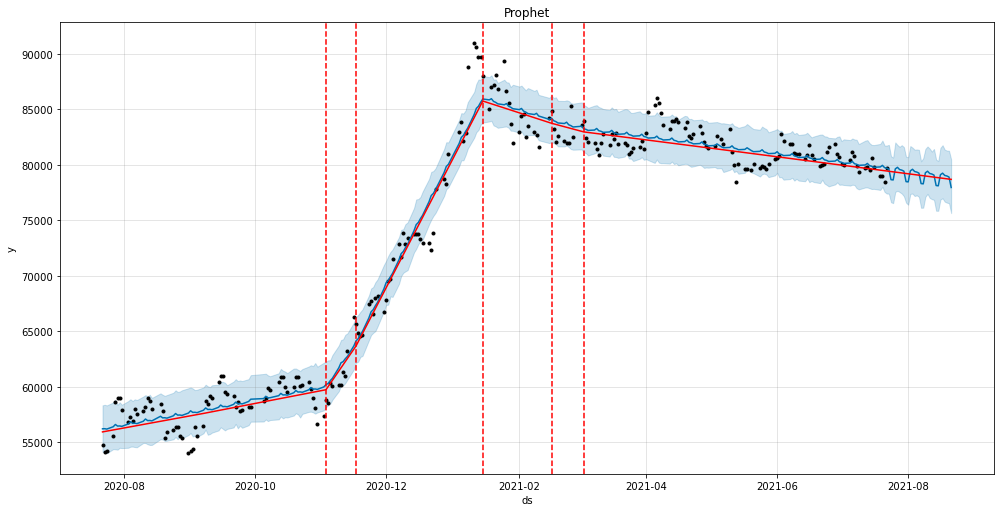

In [5]:
prophet = Prophet(changepoint_range=1)
prophet.fit(data)
future_data = prophet.make_future_dataframe(periods=30, freq='D')
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data, figsize=(14, 7))
a = add_changepoints_to_plot(fig.gca(), prophet, forecast_data)

plt.title('Prophet')
prophet = Prophet(changepoint_range=0.4)
prophet.fit(data)
future_data = prophet.make_future_dataframe(periods=30, freq='D')
forecast_data = prophet.predict(future_data)